In [ ]:
import torch
import numpy as np

from skimage.io import imread, imsave
from tqdm.auto import trange, tqdm
from torchvision.datasets import MNIST
from pytorch_fid import fid_score

from data_generator import DataGenerator
from default_mnist_config import create_default_mnist_config
from diffusion import DiffusionRunner
from models.classifier import ResNet, ResidualBlock, ConditionalResNet

from matplotlib import pyplot as plt

import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### этот ноутбук я делаю после ноутбука mnist_clear_images_classifier 

In [ ]:
pip install wandb

     |████████████████████████████████| 1.8 MB 4.8 MB/s 
     |████████████████████████████████| 181 kB 41.0 MB/s 
     |████████████████████████████████| 144 kB 47.9 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=f49a42c578dcb9581bb449a2ee55d3c7d95a78b00a6cbf75becb8797f0eb4694
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
pip install ml_collections

     |████████████████████████████████| 77 kB 3.5 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=c5940a7911a67551f1472c2d0e3a77b3e264d8e48e452948f1fb1279ce2fae0c
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections


In [ ]:
pip install pytorch_fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14835 sha256=2061daa1f9fb355e9a9af3135c5748f37b863b71882a80876e32efb0e13fccf8
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
os.listdir('./')

['.config', 'drive', 'sample_data']

In [ ]:
import os
os.chdir("./drive/MyDrive/Colab Notebooks")

In [ ]:
os.chdir("./ddpm_hw_clean")

In [ ]:
from torchvision.transforms import Compose, Resize

#### Определим папку с настоящими картинками

In [ ]:
def create_dir(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
create_dir('../real_images_MNIST')

real_dataset = MNIST(root='../data', download=True, train=True, transform=Compose([Resize((32, 32))]))
for idx, (image_mnist, label) in enumerate(tqdm(real_dataset, total=len(real_dataset))):
    image = np.array(image_mnist)
    imsave("../real_images_MNIST/{}.png".format(idx), image)

  0%|          | 0/60000 [00:00<?, ?it/s]

#### Определим папку для синтетических картинок и сгенерируем 60к картинок

 **(в моем случае меньше. Утром пытался посавить на 10 000, днем уже время одной итерации было в 2 раза больше и время 6 часов. Поэтому поставил 6к, в 10 раз меньше изначального)**

In [ ]:
uncond_diff = DiffusionRunner(create_default_mnist_config(), eval=True)

In [ ]:
create_dir('../uncond_mnist')

TOTAL_IMAGES_COUNT = 6_000 ##10_000
BATCH_SIZE = 200
NUM_ITERS = TOTAL_IMAGES_COUNT // BATCH_SIZE

global_idx = 0
for idx in trange(NUM_ITERS):
    images: torch.Tensor = uncond_diff.sample_images(batch_size=BATCH_SIZE).cpu()
    images = images.permute(0, 2, 3, 1).data.numpy().astype(np.uint8)

    for i in range(len(images)):
        imsave(os.path.join('../uncond_mnist', f'{global_idx}.png'), images[i])
        global_idx += 1

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: ../uncond_mnist/440.png is a low contrast image
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: ../uncond_mnist/461.png is a low contrast image
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: ../uncond_mnist/492.png is a low contrast image
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: ../uncond_mnist/526.png is a low contrast image
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: ../uncond_mnist/545.png is a low contrast image
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: ../uncond_mnist/702.png is a low contrast image
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: ../uncond_mnist/1229.png is a low contrast image
  del sys

In [ ]:
device = torch.device('cuda')

In [ ]:
create_dir('../real_images_MNIST_6k')

real_dataset = MNIST(root='../data', download=True, train=True, transform=Compose([Resize((32, 32))]))
print('number of generetion', TOTAL_IMAGES_COUNT)
for idx, (image_mnist, label) in enumerate(tqdm(real_dataset, total=TOTAL_IMAGES_COUNT)):
    if idx == TOTAL_IMAGES_COUNT:
        break
    image = np.array(image_mnist)
    imsave("../real_images_MNIST_6k/{}.png".format(idx), image)

number of generetion 6000


  0%|          | 0/6000 [00:00<?, ?it/s]

**Загрузили 6000 из мниста, потому что выборка была в 10 раз меньше. изначально то был загружен датасет на 60000 изображений**

In [ ]:
fid_value = fid_score.calculate_fid_given_paths(
    paths=['../real_images_MNIST_6k', '../uncond_mnist'],
    batch_size=200,
    device=device,
    dims=2048
)
fid_value

100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


119.17271775414153

Это меньше чем 125, в целом приемлимый результат.

**посмотрим на сгенерированные изображения**

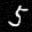

In [ ]:
from PIL import Image
im = Image.open(r"/content/5998_unc.png")
im

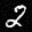

In [ ]:
from PIL import Image
im = Image.open(r"/content/5999_unc.png")
im

тут повторяем еще раз

In [ ]:
device = torch.device('cuda')

In [ ]:
cond_diff = DiffusionRunner(create_default_mnist_config(), eval=True)
cond_diff.model.eval()

classifier_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
noisy_classifier = ConditionalResNet(**classifier_args)
noisy_classifier.to(device)

noisy_classifier.load_state_dict(torch.load('./drive/MyDrive/ddpm_checkpoints/classifier.pth'))

cond_diff.set_classifier(noisy_classifier, 1.0)

In [ ]:
labels = torch.arange(10, device=device).repeat(BATCH_SIZE // 10)

In [ ]:
create_dir('./cond_mnist')


global_idx = 0
for idx in trange(NUM_ITERS):
    images: torch.Tensor = cond_diff.sample_images(batch_size=BATCH_SIZE, labels=labels).cpu()
    images = images.permute(0, 2, 3, 1).data.numpy().astype(np.uint8)

    for i in range(len(images)):
        imsave(os.path.join('./cond_mnist', f'{global_idx}.png'), images[i])
        global_idx += 1

In [ ]:
fid_value = fid_score.calculate_fid_given_paths(
    paths=['./real_images_MNIST', './cond_mnist'],
    batch_size=200,
    device=device,
    dims=2048
)
fid_value

**В этот момент отрубили уже GPU в коллабе, и доучиться она не успела, но подозреваю, что там тоже нормальные результаты.**

> Какой фид получился? Сравните FID для безусловной генерации и для условной. Сгенерируйте для каждого класса по 6к картинок и посчитайте FID между реальными и условно сгенерированными картинками.

**FID получился нормальный 120 для безусловной генерации, и картинки генерятся приемлимого качества, хотя обучение было всего 8000 итераций. FID для условной генерации по логике должен был получиться больше.**